# BEC Imaging Simulation

Simulations of interest
- Single Atom
    - Thermal Single Atom
    - Bimodal Single Atom
    - Ground-State Single Atom
- 11 Atoms
    - Thermal All (i.e. mot insulator-like)
    - Ground-State all
        - Close-spaced
        - Far-Spaced


In [1]:
%config Completer.use_jedi = False

In [2]:
from matplotlib import style
import matplotlib as mpl
from matplotlib import cm

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as pltstyle
from matplotlib import cm
#pltstyle.use('dark_background')
from Analysis_Python_Files.fitters.Gaussian import arb_2d_sum, gaussian_2d, bump
from Analysis_Python_Files.fitters import LargeBeamMotExpansion
import matplotlib.animation as animation
from Analysis_Python_Files import MatplotlibPlotters as mp
from matplotlib import cm
from matplotlib.colors import ListedColormap
import scipy.optimize as opt
from Analysis_Python_Files import AnalysisHelpers as ah
from Analysis_Python_Files import Miscellaneous as misc
from IPython.display import HTML
from Analysis_Python_Files import MarksConstants as mc
from Analysis_Python_Files import MarksFourierAnalysis as fa
import scipy.ndimage as ndimage
import IPython

In [4]:
if False:
    # My Dark Settings
    style.use(['dark_background'])
    c = '#0A0A0A'
    mpl.rcParams['axes.facecolor'] = '#000000'
    mpl.rcParams['figure.edgecolor'] = c
    mpl.rcParams['figure.facecolor'] = c
else:
    # My Light Settings
    style.use(['default'])
    c = '#FFFFFF'
    mpl.rcParams['axes.facecolor'] = c
    mpl.rcParams['figure.edgecolor'] = c
    mpl.rcParams['figure.facecolor'] = c  
# the default cycling of colors in this mode isn't very good.
#rcParams['axes.prop_cycle'] = ("cycler('color', ['r','c','g','#FFFFFF','b']) + cycler('marker', ['o','v','<','>','^'])")
### General
mpl.rcParams['figure.figsize'] = (25.0, 8.0)
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams['grid.alpha'] = 0.15
mpl.rcParams['axes.formatter.limits'] = (-3,3)
mpl.rcParams['image.cmap'] = 'viridis'
#rcParams['image.cmap'] = dark_viridis_cmap
# to see all available options, decomment this line.
# print(mpl.rcParams)
mpl.rcParams['font.size'] = 14
viridis = cm.get_cmap('viridis', 256)
dark_viridis = []
bl = 0.15
for i in range(256):
    dark_viridis.append(list(viridis(i)))
    dark_viridis[-1][0] = dark_viridis[-1][0] *(bl+(1-bl)*i/255)
    dark_viridis[-1][1] = dark_viridis[-1][1] *(bl+(1-bl)*i/255)
    dark_viridis[-1][2] = dark_viridis[-1][2] *(bl+(1-bl)*i/255)
dark_viridis_cmap = ListedColormap(dark_viridis)

In [5]:
viridis = cm.get_cmap('viridis', 256)
dark_viridis = []
bl = 0.15
for i in range(256):
    dark_viridis.append(list(viridis(i)))
    dark_viridis[-1][0] = dark_viridis[-1][0] *(bl+(1-bl)*i/255)
    dark_viridis[-1][1] = dark_viridis[-1][1] *(bl+(1-bl)*i/255)
    dark_viridis[-1][2] = dark_viridis[-1][2] *(bl+(1-bl)*i/255)
dark_viridis_cmap = ListedColormap(dark_viridis)

In [6]:
def animateImageSeries(times, images, hIntData=None, vIntData=None, interval=10,
                      imshow_args = None, yticklabels=None, ylabel=None, normalizeImages=True):
    if imshow_args == None:
        imshow_args = {'cmap':dark_viridis_cmap}
    maxInit = max(images[0].flatten())
    imshow_args.update( {'vmin':0, 'vmax':maxInit})
    Z = np.zeros(images[0].shape)
    fig = plt.figure(figsize=(7,5))
    ax = plt.axes()
    if hIntData == None and vIntData == None:
        im = ax.imshow(Z, **imshow_args)
    else:
        res = mp.fancyImshow(fig, ax, Z, imageArgs=imshow_args);
        ax, cax, hax, vax, hAvg, vAvg, im, vintline, hintline = res
        cax.set_yticklabels([])
        hax.set_yticklabels(yticklabels)
        hax.set_ylabel(ylabel)        
        hax.set_xlim(0,max(hIntData[0]))
        vax.set_ylim(0,max(vIntData[0]))
    def init():
        im.set_data(np.zeros(Z.shape))
        return
    def animateFunc(n, *args, **kwargs):
        misc.loopProgress(n, len(times),"Image Series Progress: ", clear=True)
        if animateFunc.tb is not None:
            animateFunc.tb.set_visible(False)
        animateFunc.tb = ax.text(0.1, 0.1, r'$t='+misc.round_sig_str(times[n]*1e6)+' \mu s$',
                             bbox=dict(facecolor='k', alpha=1), 
                             color='w', fontsize=15, transform=ax.transAxes)
        maxn =  max(images[n].flatten())
        im.set_data(images[n] * maxInit / maxn)
        if hIntData == None and vIntData == None:
            return
        hintline[0].set_data(hIntData[n], np.arange(len(hIntData[n])))
        vintline[0].set_data(np.arange(len(vIntData[n])), vIntData[n])
        vax.set_ylim(0,max(vIntData[n]))
        hax.set_xlim(0,max(hIntData[n]))
        return
    animateFunc.tb = None
    ani = animation.FuncAnimation(fig, animateFunc, init_func=init, frames=len(images), interval=interval, blit=False, repeat=True)
    plt.close()
    return HTML(ani.to_html5_video())

## Simple double-ballistic expansion

In [7]:
def calculateImages(spacing, numG, numImages=200):
    mag = 40
    pixToM = 16e-6/mag
    x = np.arange(-20e-6,20e-6,pixToM)
    y = np.arange(-10e-6,10e-6,pixToM)
    X, Y = np.meshgrid(x,y)
    # in meters
    w0 = 0.5e-6
    # in K
    temp_0 = 7e-6
    fraction0 = 0.3
    temp_1 = 70e-6
    times = np.linspace(0,0.03e-3,numImages)
    standardArea = gaussian_2d.areaUnder(1, w0, w0)
    images, hIntData, vIntData = [[],[],[]]
    for time in times:
        gaussParams = [0]
        waist = LargeBeamMotExpansion.f(time, 0, w0, temp_0)
        amp = fraction0*standardArea/gaussian_2d.areaUnder(1, waist, waist)
        waist2 = LargeBeamMotExpansion.f(time, 0, w0, temp_1)
        amp2 = (1-fraction0)*standardArea/gaussian_2d.areaUnder(1, waist2, waist2)
        # cold ones
        for num in range(numG):
            gaussParams = np.append(gaussParams, [amp, num*spacing - ((numG-1)/2*spacing), 0, waist, waist])
        # hot ones
        for num in range(numG):
            gaussParams = np.append(gaussParams, [amp2, num*spacing - ((numG-1)/2*spacing), 0, waist2, waist2])
        images.append(arb_2d_sum.f((X,Y), *gaussParams).reshape(X.shape))
        hAvg, vAvg = ah.collapseImage(images[-1])
        hIntData.append(hAvg)
        vIntData.append(vAvg)
        guess = [max(vAvg), 50, waist/pixToM, 0]
        param, cov = opt.curve_fit(bump.f, np.arange(len(vAvg)), vAvg, p0=guess)
    return images, hIntData, vIntData
        # fig, ax = plt.subplots(figsize=(10,10))
        # mp.fancyImshow(fig, ax, images[-1],vFitParams=param, fitModule=bump, avgSize='30%', subplotsAdjustArgs={'left':0.1, 'right':0.9});
        # rss = misc.round_sig_str
        # ax.set_title('fit=' + rss(param[-2]*pixToM*2e6) + ', w1=' + rss(waist*2e6) + ', w2=' +  rss(waist2*2e6) + ' um', fontsize=12)    

### Single

In [ ]:
images, hIntDFata, vIntData = calculateImages(0, 1, numImages=200)
animateImageSeries(images, hIntDFata, vIntData)

### Wide Array

In [ ]:
images, hIntDFata, vIntData = calculateImages(2e-6, 11)
animateImageSeries(images, hIntDFata, vIntData)

### narrow spacing

In [ ]:
images, hIntDFata, vIntData = calculateImages(0.7e-6, 11)
animateImageSeries(images, hIntDFata, vIntData)

## Quantum Expansion

$$ E = \frac{p^2}{2m} = \frac{\hbar^2 k^2}{2m} $$

Free space eigenfunctions are 
$$
\psi\{r\}\propto \exp\{i\vec{r}\bullet\vec{k}+\phi\}\exp\{-iEt/\hbar\}= \exp\{i\vec{r}\bullet\vec{k}+\phi\}\exp\{-i\hbar k^2t/2m\}
$$

So the procedure should be:
- Decompose initial wavefunction into fourier components
- calculate phase evolution of each component at time t
- recompose final wavefunction

### 1D Gaussian

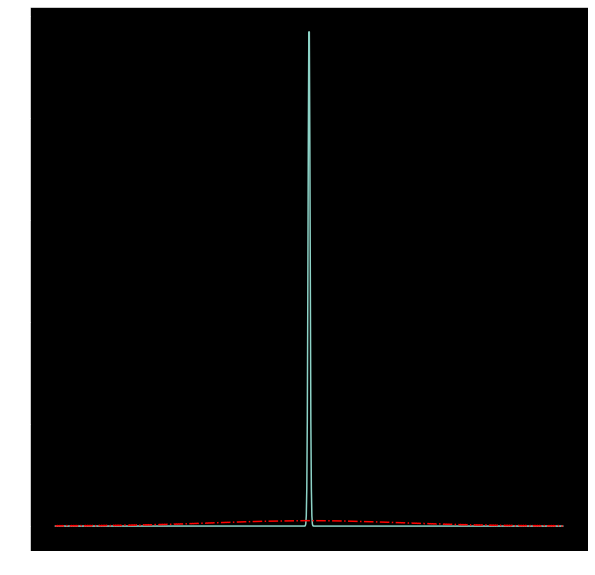

In [4]:
xpts = np.linspace(-5e-6,5e-6,1000)
sig0 = 39.4e-9*np.sqrt(2)/2
ypts = bump.f(xpts, 1, 0, sig0, 0)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(xpts*1e6,abs(ypts)**2)
res = fa.fft(ypts, xpts)
kvals = res['Freq'] * 2 * np.pi
propTime = 1e-4
for i, k in enumerate(kvals):
    factor = np.exp(-1j*mc.hbar*k**2*propTime/(2*mc.Rb87_M))
    res['Field'][i] *= factor
finWF = fa.ifft(res['Field'], xpts)
ax.plot(finWF['xpts']*1e6,abs(finWF['Field'])**2,'r-.')

### 2D Gaussian

In [5]:
from importlib import reload

In [141]:
def SchrodingerPropagate(numG, spacing, picSize=30e-6, fit=False, maxtime=2e-4, numtimes=100, waistAsymFactor=1, initsigma=39.4e-9*np.sqrt(2)/2):
    numpts = 1000
    pixsize = picSize/numpts
    ypts = xpts = np.linspace(-picSize/2,picSize/2,numpts)

    X, Y = np.meshgrid(xpts,ypts)
    # From my other notebook's analysis, the waist of P(x) is 39.4e-9 m for the ground state in a ~150kHz trap.
    # The waist of psi(x) is then this waist * sqrt(2), and I'm plugging in psi into the calculation not P(x), so 
    # it's important to multiply by sqrt(2) here. 
    sig0 = initsigma
    #numG = 1
    gaussArgs = [0]
    #spacing = 0
    for num in range(numG):
        gaussArgs += [1, num*spacing - (numG-1)*spacing/2, 0, sig0*waistAsymFactor, sig0]
    zpts = np.reshape(arb_2d_sum.f((X,Y), *gaussArgs),X.shape)
    #zpts = np.reshape(gaussian_2d.f((X,Y), 1, 0, 0, sig0,sig0, 0, 0),X.shape)
    res = fa.fft2D(zpts, xpts, ypts)
    kx = res['xFreq'] * 2 * np.pi
    ky = res['yFreq'] * 2 * np.pi
    times = np.linspace(0,maxtime,numtimes)
    kMatrix = np.zeros(zpts.shape)
    for i, kx_ in enumerate(kx):
        for j, ky_ in enumerate(ky):
            kMatrix[i,j] = kx_**2+ky_**2
    fits, havgs, vavgs, images = [[] for _ in range(4)]
    for timei, time in enumerate(times):
        misc.loopProgress(timei, len(times), "Schrodinger Propagate Progress: ")
        factorMatrix = np.exp(-1j*mc.hbar*kMatrix*time/(2*mc.Rb87_M))
        propMomentumSpace = res['Field'] * factorMatrix
        finWF = fa.ifft2D(propMomentumSpace, xpts, ypts)
        images.append(abs(finWF['Field'])**2)
        h_, v_ = ah.collapseImage(images[-1])
        if fit:
            p_, cov = opt.curve_fit(bump.f, xpts, h_, p0=[1, 0, sig0, 0])
            fits.append(p_)
        havgs.append(h_)
        vavgs.append(v_)
    return images, fits, havgs, vavgs, pixsize, times

In [293]:
images, fits, havgs, vavgs, pixsize, times = SchrodingerPropagate(1,0, numtimes=101)

99.0 % Complete...


In [294]:
sigmas = [f[2] for f in fits]
param, cov = opt.curve_fit(LargeBeamMotExpansion.f, times, np.array(sigmas), p0=[0, sigmas[0], 7.2e-6]);
print(param[-1]*1e6)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(times, sigmas, 'c', linewidth=5)
xpts_exp = np.linspace(min(times), max(times), 1000)
ax.plot(xpts_exp, LargeBeamMotExpansion.f(xpts_exp, *param), 'r:')

IndexError: list index out of range

In [9]:
scale = (30e-6/5)
realYticklabels = [misc.round_sig_str(scale*i*1e6) for i in range(6)]
print(realYticklabels)

['0.00', '6.00', '12.0', '18.0', '24.0', '30.0']


In [296]:
animateImageSeries(times, images, interval=100, hIntData=havgs, vIntData=vavgs, 
                   imshow_args={'cmap':'inferno'}, yticklabels=realYticklabels, ylabel=r'distance ($\mu m$)')

99.0 % Complete...


#### with camera image blur and binning

In [31]:
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

In [140]:
def simCamera(images, pixsize):
    camHavg, camVavg, camImages = [[] for _ in range(3)]
    for inc, im in enumerate(images):
        misc.loopProgress(inc, len(images))
        blurredIm = ndimage.gaussian_filter(im, sigma=0.3e-6/pixsize)
        binnedIm = rebin(blurredIm[:-12,:-12], (76, 76))
        camImages.append(binnedIm)
        havg, vavg = ah.collapseImage(camImages[-1])
        camHavg.append(havg)
        camVavg.append(vavg)
    return camImages, camHavg, camVavg

In [297]:
camImages, camHavg, camVavg = simCamera(images, pixsize)

99.0 % Complete...


In [35]:
scale = (30e-6*((1000-12)/1000)/7)
camYticklabels = [misc.round_sig_str(scale*i*1e6) for i in range(8)]
print(camYticklabels)

['0.00', '4.23', '8.47', '12.7', '16.9', '21.2', '25.4', '29.6']


In [299]:
animateImageSeries(times, camImages, interval=100, hIntData=camHavg, vIntData=camVavg, 
                   imshow_args={'cmap':'inferno'}, yticklabels=camYticklabels, ylabel=r'distance ($\mu m$)')

99.0 % Complete...


### 11 ground-state wide

In [300]:
images, fits, havgs, vavgs, pixsize, times = SchrodingerPropagate(11,2e-6, picSize=60e-6, numtimes=101)

99.0 % Complete...


In [301]:
animateImageSeries(times, images, interval=100, hIntData=havgs, vIntData=vavgs, 
                   imshow_args={'cmap':'inferno'}, yticklabels=realYticklabels, ylabel=r'distance ($\mu m$)')

99.0 % Complete...


In [302]:
camImages, camHavg, camVavg = simCamera(images, pixsize)

99.0 % Complete...


In [303]:
animateImageSeries(times, camImages, interval=100, hIntData=camHavg, vIntData=camVavg, 
                   imshow_args={'cmap':'inferno'}, yticklabels=camYticklabels, ylabel=r'distance ($\mu m$)')

99.0 % Complete...


### 11 Ground-state Narrow

#### settings A

In [270]:
39.4e-9*np.sqrt(2)/2*1e9

27.860007178749978

In [304]:
images, fits, havgs, vavgs, pixsize, times = SchrodingerPropagate(11,0.75e-6, picSize=30e-6, maxtime=10e-4, waistAsymFactor=2, initsigma=90e-9, numtimes=101)

99.0 % Complete...


In [306]:
animateImageSeries(times, images, interval=100, hIntData=havgs, vIntData=vavgs, 
                   imshow_args={'cmap':'inferno'}, yticklabels=realYticklabels, ylabel=r'distance ($\mu m$)')

99.0 % Complete...


In [307]:
camImages, camHavg, camVavg = simCamera(images, pixsize)

99.0 % Complete...


In [308]:
animateImageSeries( times, camImages, interval=100, hIntData=camHavg, vIntData=camVavg, 
                    imshow_args={'cmap':'inferno'}, yticklabels=camYticklabels, ylabel=r'distance ($\mu m$)')

99.0 % Complete...


#### settings B

In [309]:
images, fits, havgs, vavgs, pixsize, times = SchrodingerPropagate(11, 0.5e-6, picSize=30e-6, maxtime=10e-4, waistAsymFactor=2, initsigma=90e-9, numtimes=101)

99.0 % Complete...


In [310]:
animateImageSeries(times, images, interval=100, hIntData=havgs, vIntData=vavgs, 
                   imshow_args={'cmap':'inferno'}, yticklabels=realYticklabels, ylabel=r'distance ($\mu m$)')

99.0 % Complete...


In [311]:
camImages, camHavg, camVavg = simCamera(images, pixsize)

99.0 % Complete...


In [312]:
animateImageSeries( times, camImages, interval=100, hIntData=camHavg, vIntData=camVavg, 
                    imshow_args={'cmap':'inferno'}, yticklabels=camYticklabels, ylabel=r'distance ($\mu m$)')

99.0 % Complete...


#### settings C

In [313]:
images, fits, havgs, vavgs, pixsize, times = SchrodingerPropagate(11, 1e-6, picSize=30e-6, maxtime=10e-4, waistAsymFactor=2, initsigma=90e-9, numtimes=101)

99.0 % Complete...


In [314]:
animateImageSeries(times, images, interval=100, hIntData=havgs, vIntData=vavgs, 
                   imshow_args={'cmap':'inferno'}, yticklabels=realYticklabels, ylabel=r'distance ($\mu m$)')

99.0 % Complete...


In [315]:
camImages, camHavg, camVavg = simCamera(images, pixsize)

99.0 % Complete...


In [316]:
animateImageSeries( times, camImages, interval=100, hIntData=camHavg, vIntData=camVavg, 
                    imshow_args={'cmap':'inferno'}, yticklabels=camYticklabels, ylabel=r'distance ($\mu m$)')

99.0 % Complete...


## Excited States

### (0,1)

In [14]:
from Analysis_Python_Files.fitters.Gaussian import bump

In [15]:
numpts = 1000
picSize=30e-6
pixsize = picSize/numpts
ypts = xpts = np.linspace(-picSize/2,picSize/2,numpts)
X, Y = np.meshgrid(xpts,ypts)

In [8]:
def incoherentSum(nx, ny, picSize=30e-6, fit=False, maxtime=2e-4, numtimes=100, waistAsymFactor=1, initsigma=39.4e-9*np.sqrt(2)/2):
    if (type(nx) != type(ny)) or type(nx) != list:
        raise RuntimeError("Expected lists for nx and ny")
    images_total, havgs_total, vavgs_total = [[] for _ in range(3)]
    for nx_, ny_ in zip(nx, ny):
        images, fits, havgs, vavgs, pixsize, times = SchrodingerPropagateExcited(nx_, ny_, picSize, fit, maxtime, numtimes,  initsigma)
        images_total.append(images)
        havgs_total.append(havgs)
        vavgs_total.append(vavgs)
    imageAvg = np.mean(images_total, 0)
    havgsAvg = np.mean(havgs_total,0)
    vavgsAvg = np.mean(vavgs_total,0)
    return imageAvg, fits, havgsAvg, vavgsAvg, pixsize, times

$$\sigma_x = \sqrt{\frac{\hbar}{m\omega}}$$

In [82]:
1/((39.4e-9*np.sqrt(2)/2)**2*mc.Rb87_M/mc.hbar)/(2*np.pi)

149837.01062198443

def SchrodingerPropagateExcited(nx, ny, picSize=30e-6, fit=False, maxtime=2e-4, numtimes=100, waistAsymFactor=1, initsigma=39.4e-9*np.sqrt(2)/2):
    numpts = 1000
    pixsize = picSize/numpts
    ypts = xpts = np.linspace(-picSize/2,picSize/2,numpts)
    X, Y = np.meshgrid(xpts,ypts)
    # From my other notebook's analysis, the waist of P(x) is 39.4e-9 m for the ground state in a ~150kHz trap.
    # The waist of psi(x) is then this waist * sqrt(2), and I'm plugging in psi into the calculation not P(x), so 
    # it's important to multiply by sqrt(2) here. 
    sig0 = initsigma
    zpts = np.zeros(X.shape)
    if type(nx) == list and coherentSum:
        for nx_, ny_ in zip(nx, ny):
            psix = bump.f(X, 1, 0, sig0, 0) * (X if nx_ == 1 else 1)
            psiy = bump.f(Y, 1, 0, sig0, 0) * (Y if ny_ == 1 else 1)
            zpts += psix*psiy
    else:
        psix = bump.f(X, 1, 0, sig0, 0) * (X if nx == 1 else 1)
        psiy = bump.f(Y, 1, 0, sig0, 0) * (Y if ny == 1 else 1)
        zpts = psix*psiy
    res = fa.fft2D(zpts, xpts, ypts)
    kx = res['xFreq'] * 2 * np.pi
    ky = res['yFreq'] * 2 * np.pi
    times = np.linspace(0,maxtime,numtimes)
    kMatrix = np.zeros(zpts.shape)
    for i, kx_ in enumerate(kx):
        for j, ky_ in enumerate(ky):
            kMatrix[i,j] = kx_**2+ky_**2
    fits, havgs, vavgs, images = [[] for _ in range(4)]
    for timei, time in enumerate(times):
        misc.loopProgress(timei, len(times), "Schrodinger Propagate Excited Progress: ")
        factorMatrix = np.exp(-1j*mc.hbar*kMatrix*time/(2*mc.Rb87_M))
        propMomentumSpace = res['Field'] * factorMatrix
        finWF = fa.ifft2D(propMomentumSpace, xpts, ypts)
        images.append(abs(finWF['Field'])**2)
        h_, v_ = ah.collapseImage(images[-1])
        if fit:
            p_, cov = opt.curve_fit(bump.f, xpts, h_, p0=[1, 0, sig0, 0])
            fits.append(p_)
        havgs.append(h_)
        vavgs.append(v_)
    return images, fits, havgs, vavgs, pixsize, times

In [19]:
images, fits, havgs, vavgs, pixsize, times = SchrodingerPropagateExcited(0,1)

99.0 % Complete...


In [94]:
scale = (30e-6/5)
realYticklabels = [misc.round_sig_str(scale*i*1e6) for i in range(6)]
print(realYticklabels)

['0.00', '6.00', '12.0', '18.0', '24.0', '30.0']


#### figuring out how to save and import the data

In [39]:
with open('2dExcitedStateExpansion.csv','wb') as datafile:
    for image in images:
        for row in image:
            for dp in row:
                datafile.write((str(dp)+',').encode('ascii'))
        datafile.write('\n'.encode('ascii'))
    #pickle.dump(images, datafile)

In [41]:
with open('2dExcitedStateExpansion.csv','rb') as datafile:
    images_f = datafile.readlines()

In [75]:
imageArray = []
for imagenum, imageStr in enumerate(images_f):
    misc.reportProgress(imagenum, len(images_f))
    imageListStr = imageStr.split(b',')
    imageList = [float(dp) for dp in imageListStr[:-1]]
    imageArray.append(np.reshape(imageList,(1000,1000)))

In [76]:
np.array(imageArray).shape

(100, 1000, 1000)

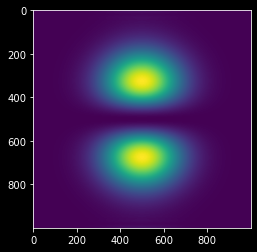

In [77]:
plt.imshow(imageArray[-1])

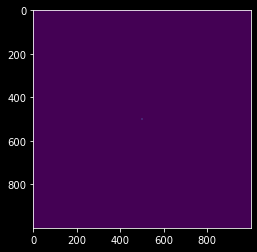

In [78]:
plt.imshow(imageArray[0])

In [65]:
imageArray.shape

(1000000,)

In [56]:
image1 = 

In [22]:
animateImageSeries(times, images, interval=100, hIntData=havgs, vIntData=vavgs, 
                   imshow_args={'cmap':'inferno'}, yticklabels=realYticklabels, ylabel=r'distance ($\mu m$)')

99.0 % Complete...


In [21]:
scale = (30e-6/5)
realYticklabels = [misc.round_sig_str(scale*i*1e6) for i in range(6)]
print(realYticklabels)

['0.00', '6.00', '12.0', '18.0', '24.0', '30.0']


In [45]:
camImages, camHavg, camVavg = simCamera(images, pixsize)

99.0 % Complete...


In [46]:
animateImageSeries( times, camImages, interval=100, hIntData=camHavg, vIntData=camVavg, 
                    imshow_args={'cmap':'inferno'}, yticklabels=camYticklabels, ylabel=r'distance ($\mu m$)')

99.0 % Complete...


### (1,1)

In [47]:
images, fits, havgs, vavgs, pixsize, times = SchrodingerPropagateExcited(1,1)

99.0 % Complete...


In [50]:
animateImageSeries(times, images, interval=100, hIntData=havgs, vIntData=vavgs, 
                   imshow_args={'cmap':'inferno'}, yticklabels=realYticklabels, ylabel=r'distance ($\mu m$)')

99.0 % Complete...


In [51]:
camImages, camHavg, camVavg = simCamera(images, pixsize)

99.0 % Complete...


In [52]:
animateImageSeries( times, camImages, interval=100, hIntData=camHavg, vIntData=camVavg, 
                    imshow_args={'cmap':'inferno'}, yticklabels=camYticklabels, ylabel=r'distance ($\mu m$)')

99.0 % Complete...


### (1,0) + (0,1)

In [74]:
images, fits, havgs, vavgs, pixsize, times = SchrodingerPropagateExcited([1,0],[0,1])

99.0 % Complete...


In [55]:
animateImageSeries(times, images, interval=100, hIntData=havgs, vIntData=vavgs, 
                   imshow_args={'cmap':'inferno'}, yticklabels=realYticklabels, ylabel=r'distance ($\mu m$)')

99.0 % Complete...


In [56]:
camImages, camHavg, camVavg = simCamera(images, pixsize)

99.0 % Complete...


In [57]:
animateImageSeries( times, camImages, interval=100, hIntData=camHavg, vIntData=camVavg, 
                    imshow_args={'cmap':'inferno'}, yticklabels=camYticklabels, ylabel=r'distance ($\mu m$)')

99.0 % Complete...


### incoherent (1,0) & (0,1)

In [80]:
images, fits, havgs, vavgs, pixsize, times = incoherentSum([1,0],[0,1])

99.0 % Complete...


In [81]:
havgs = list(havgs)
vavgs = list(vavgs)

In [82]:
animateImageSeries(times, images, interval=100, hIntData=havgs, vIntData=vavgs, 
                   imshow_args={'cmap':'inferno'}, yticklabels=realYticklabels, ylabel=r'distance ($\mu m$)')

99.0 % Complete...


In [83]:
camImages, camHavg, camVavg = simCamera(images, pixsize)

99.0 % Complete...


In [84]:
animateImageSeries( times, camImages, interval=100, hIntData=camHavg, vIntData=camVavg, 
                    imshow_args={'cmap':'inferno'}, yticklabels=camYticklabels, ylabel=r'distance ($\mu m$)')

99.0 % Complete...


# Thermal Calculations

In [9]:
scale = (30e-6/5)
realYticklabels = [misc.round_sig_str(scale*i*1e6) for i in range(6)]
print(realYticklabels)

['0.00', '6.00', '12.0', '18.0', '24.0', '30.0']


In [10]:
def harmonicOscillatorSolution(xp, n_x, nu_x):
    term = mc.Rb87_M*2*np.pi*nu_x/mc.hbar
    hermiteCoef = [0 for _ in range(n_x+1)]
    hermiteCoef[n_x] = 1
    hermiteF = np.polynomial.hermite.Hermite(hermiteCoef)
    t1 = 1/np.sqrt(2**float(n_x)*np.math.factorial(float(n_x)))
    t2 =  (term/np.pi)**(1/4)
    t3=np.exp(-term*xp**2/2)
    t4=hermiteF(np.sqrt(term)*xp)
    return  t1 * t2 * t3 *t4


Normalized? 1.0000000000000089
Normalized? 0.9999999999985785
Normalized? 0.9999999999576776
Normalized? 0.9999999992056848
Normalized? 0.9999999892187259
Normalized? 0.999999887254416
Normalized? 0.9999990557094696
Normalized? 0.9999935003302413
Normalized? 0.9999625678879767
Normalized? 0.9998173262140049


Text(0.5, 1.0, '$|\\psi|^2$')

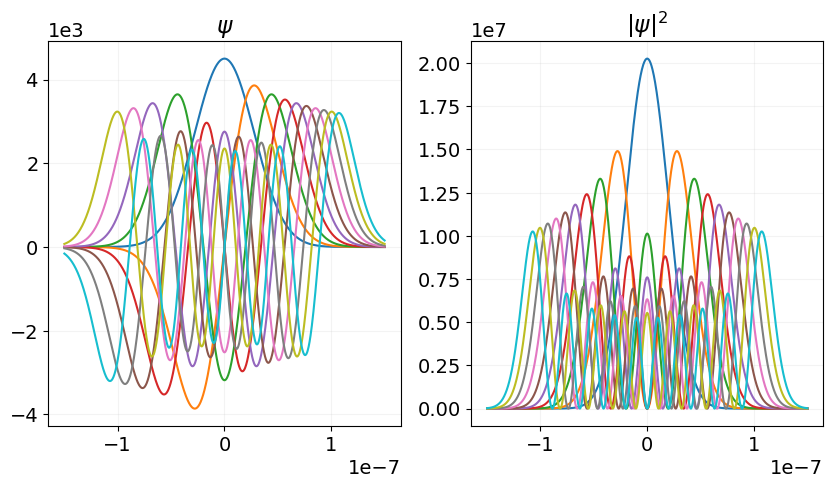

In [17]:
xpts = np.linspace(-0.15e-6,0.15e-6,1000)
fig, axs = plt.subplots(1,2, figsize=(10,5))
for nx in range(10):
    axs[0].plot(xpts, harmonicOscillatorSolution(xpts, nx, 150e3), label=nx)
    axs[1].plot(xpts, harmonicOscillatorSolution(xpts, nx, 150e3)**2, label=nx)
    print('Normalized?',sum(harmonicOscillatorSolution(xpts, nx, 150e3)**2*(xpts[1]-xpts[0])))
axs[0].set_title('$\psi$')
axs[1].set_title('$|\psi|^2$')

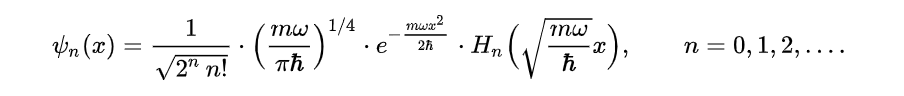


In [ ]:
fig, axs = plt.subplots(3,3, figsize=(10,10))
for ax, relativePop in zip(axs.flatten(), np.linspace(0,1,9)):
    images, fits, havgs, vavgs, pixsize, times, images_total = incoherentSum([1,0],[0,0], [relativePop,(1-relativePop)], numtimes=10)
    mp.fancyImshow(fig, ax, images[5], subplotsAdjustArgs={'left': 0, 'bottom': 0, 'right': 1, 'top': 1, 'wspace': 0.1, 'hspace': 0.1},
                   ticklabels=False, cb=False)
    ax.set_title(misc.round_sig_str(relativePop*100)+'% Excited')

In [ ]:
animateImageSeries(times, images, interval=100, hIntData=list(havgs), vIntData=list(vavgs), 
                   imshow_args={'cmap':'inferno'}, yticklabels=realYticklabels, ylabel=r'distance ($\mu m$)')

In [ ]:
animateImageSeries(times, images, interval=100, hIntData=list(havgs), vIntData=list(vavgs), 
                   imshow_args={'cmap':'inferno'}, yticklabels=realYticklabels, ylabel=r'distance ($\mu m$)')

## at various temperatures...

$$ \bar{n} = \frac{1}{e^{\beta\hbar \omega}-1}$$

In [11]:
from importlib import reload

In [12]:
def SchrodingerPropagateExcited(nx, ny, picSize=30e-6, fit=False, maxtime=2e-4, numtimes=100, numpts=1000, nu=150e3, clear=False):
    pixsize = picSize/numpts
    ypts = xpts = np.linspace(-picSize/2,picSize/2,numpts)
    X, Y = np.meshgrid(xpts,ypts)
    zpts = np.zeros(X.shape)
    if type(nx) == list and coherentSum:
        for nx_, ny_ in zip(nx, ny):
            psix = harmonicOscillatorSolution(X, nx_, nu)
            psiy = harmonicOscillatorSolution(Y, ny_, nu)
            zpts += psix*psiy
    else:
        psix = harmonicOscillatorSolution(X, nx, nu)
        psiy = harmonicOscillatorSolution(Y, ny, nu)
        zpts = psix*psiy
    res = fa.fft2D(zpts, xpts, ypts)
    kx = res['xFreq'] * 2 * np.pi
    ky = res['yFreq'] * 2 * np.pi
    times = np.linspace(0,maxtime,numtimes)
    kMatrix = np.zeros(zpts.shape)
    for i, kx_ in enumerate(kx):
        for j, ky_ in enumerate(ky):
            kMatrix[i,j] = kx_**2+ky_**2
    fits, havgs, vavgs, images = [[] for _ in range(4)]
    for timei, time in enumerate(times):
        misc.loopProgress(timei, len(times), "Schrodinger Propagation Progress: ", clear=clear)
        factorMatrix = np.exp(-1j*mc.hbar*kMatrix*time/(2*mc.Rb87_M))
        propMomentumSpace = res['Field'] * factorMatrix
        finWF = fa.ifft2D(propMomentumSpace, xpts, ypts)
        images.append(abs(finWF['Field'])**2)
        h_, v_ = ah.collapseImage(images[-1])
        if fit:
            p_, cov = opt.curve_fit(bump.f, xpts, h_, p0=[1, 0, sig0, 0])
            fits.append(p_)
        havgs.append(h_)
        vavgs.append(v_)
    return images, fits, havgs, vavgs, pixsize, times

In [13]:
def incoherentSum(nx, ny, coeffs, picSize=30e-6, fit=False, maxtime=2e-4, numtimes=100, 
                  numPts=1000, nu=150e3, clear=False):
    if (type(nx) != type(ny)) or (type(nx) != list and type(nx) != type(np.array([]))):
        raise RuntimeError("Expected lists for nx and ny")
    assert(len(nx)==len(ny)==len(coeffs))
    images_total, havgs_total, vavgs_total = [[] for _ in range(3)]
    for stateNum, (nx_, ny_) in enumerate(zip(nx, ny)):
        misc.loopProgress(stateNum, len(nx), "Incoherent Sum Progress: ", clear=clear)
        res = SchrodingerPropagateExcited(nx_, ny_, picSize, fit, maxtime, numtimes, 
                                          numpts=numPts, nu=nu, clear=clear)
        images, fits, havgs, vavgs, pixsize, times = res
        images_total.append(coeffs[stateNum]*np.array(images))
        havgs_total.append(coeffs[stateNum]*np.array(havgs))
        vavgs_total.append(coeffs[stateNum]*np.array(vavgs))
    imageAvg = np.mean(images_total, 0)
    havgsAvg = np.mean(havgs_total,0)
    vavgsAvg = np.mean(vavgs_total,0)
    return imageAvg, fits, havgsAvg, vavgsAvg, pixsize, times, images_total

In [14]:
def getnbar(T):
    nu = 150e3
    if T == 0:
        return 0
    return 1/(np.exp(mc.hbar*2*np.pi*nu/(mc.k_B*T))-1)

In [15]:
def probSingleN(n,nbar):
    return nbar**n * (nbar+1)**(-n-1)

In [16]:
def getnpops(Temp, calcLength=10):
    nbar = getnbar(Temp)
    nvals = np.arange(calcLength, dtype=float)
    return [probSingleN(nv, nbar) for nv in nvals]

In [17]:
print([misc.round_sig(val) for val in getnpops(10e-6,20)])

[0.513, 0.25, 0.122, 0.0592, 0.0288, 0.014, 0.00683, 0.00332, 0.00162, 0.000788, 0.000384, 0.000187, 9.09e-05, 4.43e-05, 2.15e-05, 1.05e-05, 5.11e-06, 2.49e-06, 1.21e-06, 5.89e-07]


In [18]:
calclen = 20
reses = []
temps = np.linspace(0,20e-6,21)
for tempNum, temp in enumerate(temps):
    misc.loopProgress(tempNum, len(temps), "Different Temperatures Progress: ", True)
    res = incoherentSum( np.arange(calclen),np.zeros(int(calclen), dtype=int), getnpops(temp, calclen), 
                         numtimes=5, picSize=7e-5, numPts=4500 )
    images, fits, havgs, vavgs, pixsize, times, images_total = res
    reses.append([havgs, vavgs])

Different Temperatures Progress:  95.2 % Complete...
Incoherent Sum Progress:  0.00 % Complete...
Schrodinger Propagation Progress:  0.00 % Complete...
Schrodinger Propagation Progress:  20.0 % Complete...
Schrodinger Propagation Progress:  40.0 % Complete...
Schrodinger Propagation Progress:  60.0 % Complete...
Schrodinger Propagation Progress:  80.0 % Complete...
Incoherent Sum Progress:  5.00 % Complete...
Schrodinger Propagation Progress:  0.00 % Complete...
Schrodinger Propagation Progress:  20.0 % Complete...
Schrodinger Propagation Progress:  40.0 % Complete...
Schrodinger Propagation Progress:  60.0 % Complete...
Schrodinger Propagation Progress:  80.0 % Complete...
Incoherent Sum Progress:  10.0 % Complete...
Schrodinger Propagation Progress:  0.00 % Complete...
Schrodinger Propagation Progress:  20.0 % Complete...
Schrodinger Propagation Progress:  40.0 % Complete...
Schrodinger Propagation Progress:  60.0 % Complete...
Schrodinger Propagation Progress:  80.0 % Complete...
In

In [ ]:
calclen = 20
temp=20e-6
res = incoherentSum(np.arange(calclen),np.zeros(int(calclen), dtype=int), getnpops(temp, calclen), 
                    numtimes=5, picSize=5e-5, numPts=3000)
images, fits, havgs, vavgs, pixsize, times, images_total = res

In [ ]:
animateImageSeries(times, images, interval=100, hIntData=list(havgs), vIntData=list(vavgs), 
                   imshow_args={'cmap':'inferno'}, yticklabels=realYticklabels, ylabel=r'distance ($\mu m$)')

In [19]:
from Analysis_Python_Files import Miscellaneous as misc
from Analysis_Python_Files import AnalysisHelpers as ah

C:\Users\Mark O. Brown\Code\Data-Analysis-Code\Analysis_Python_Files\AnalysisHelpers.py:980: UserWarning: Mot Temperature Expansion Fit Failed!Covariance of the parameters could not be estimated
  warn('Mot Temperature Expansion Fit Failed!' + str(error))
C:\Users\Mark O. Brown\Code\Data-Analysis-Code\Analysis_Python_Files\AnalysisHelpers.py:980: UserWarning: Mot Temperature Expansion Fit Failed!Covariance of the parameters could not be estimated
  warn('Mot Temperature Expansion Fit Failed!' + str(error))
C:\Users\Mark O. Brown\Code\Data-Analysis-Code\Analysis_Python_Files\AnalysisHelpers.py:980: UserWarning: Mot Temperature Expansion Fit Failed!Covariance of the parameters could not be estimated
  warn('Mot Temperature Expansion Fit Failed!' + str(error))


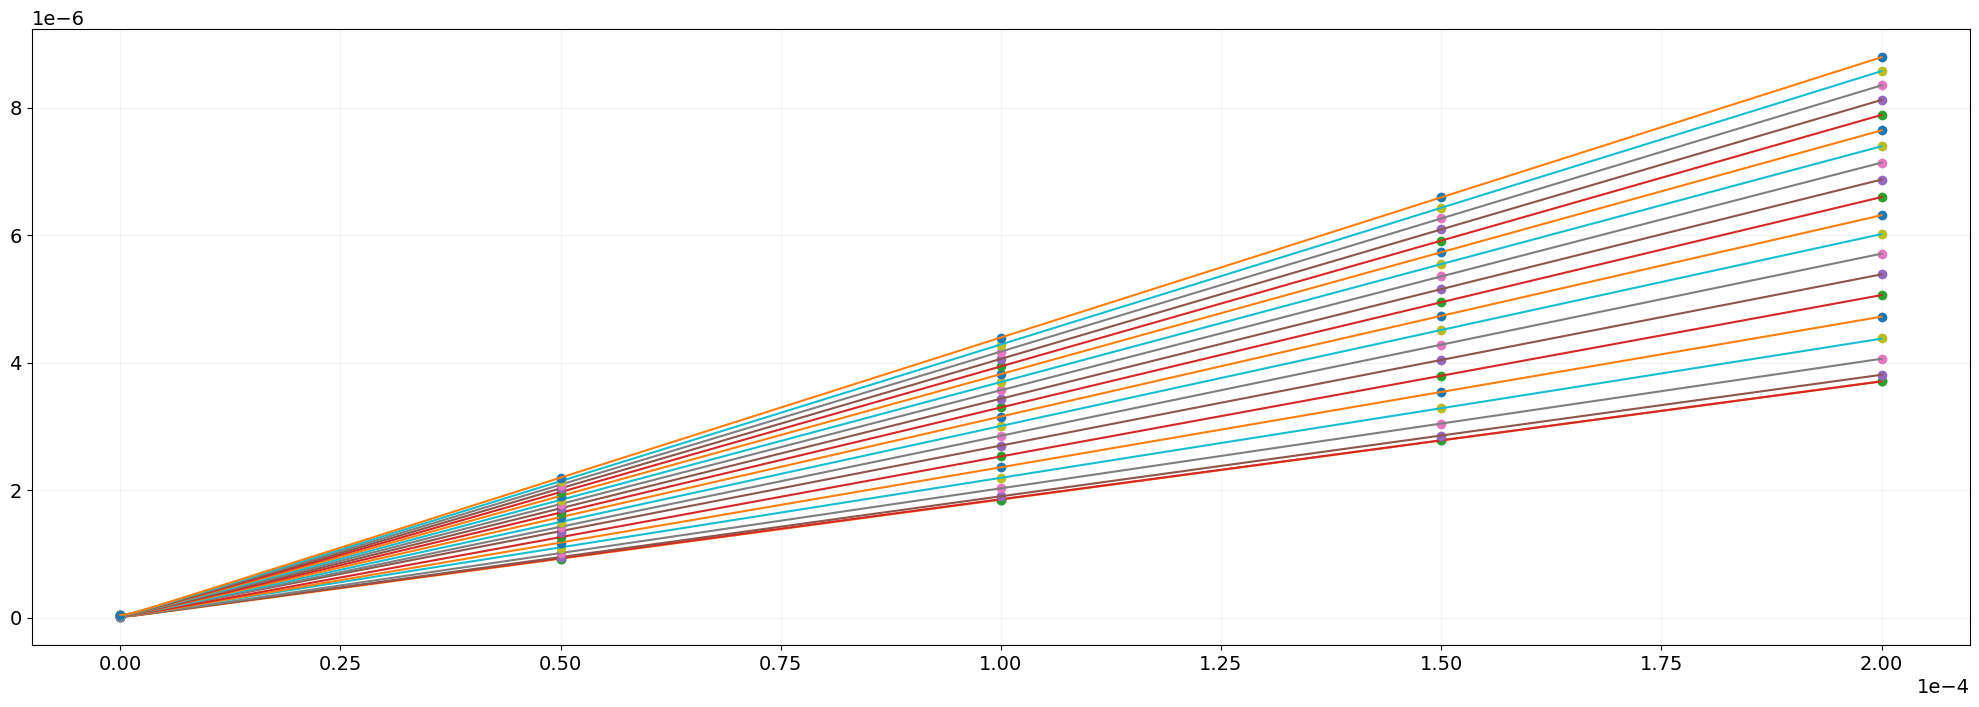

In [20]:
fig, ax = plt.subplots()
fitTimes = np.linspace(min(times),max(times),1000)
apparentTemperatures = []
for res in reses:
    #print(res[0][0])
    sigmas = []
    for vline in res[1]:
        xv = np.arange(len(vline))
        popt, covs = opt.curve_fit(bump.f, xv, vline, p0=bump.guess(xv, vline))
        sigmas.append(popt[-2]*pixsize)
    tempRes = ah.calcBallisticTemperature(times,sigmas, guess=[0,10e-9,1e-6]);
    #print(sigmas)
    ax.plot(times, sigmas,'o')
    ax.plot(fitTimes, LargeBeamMotExpansion.f(fitTimes,*tempRes[1]))
    apparentTemperatures.append(tempRes[0])

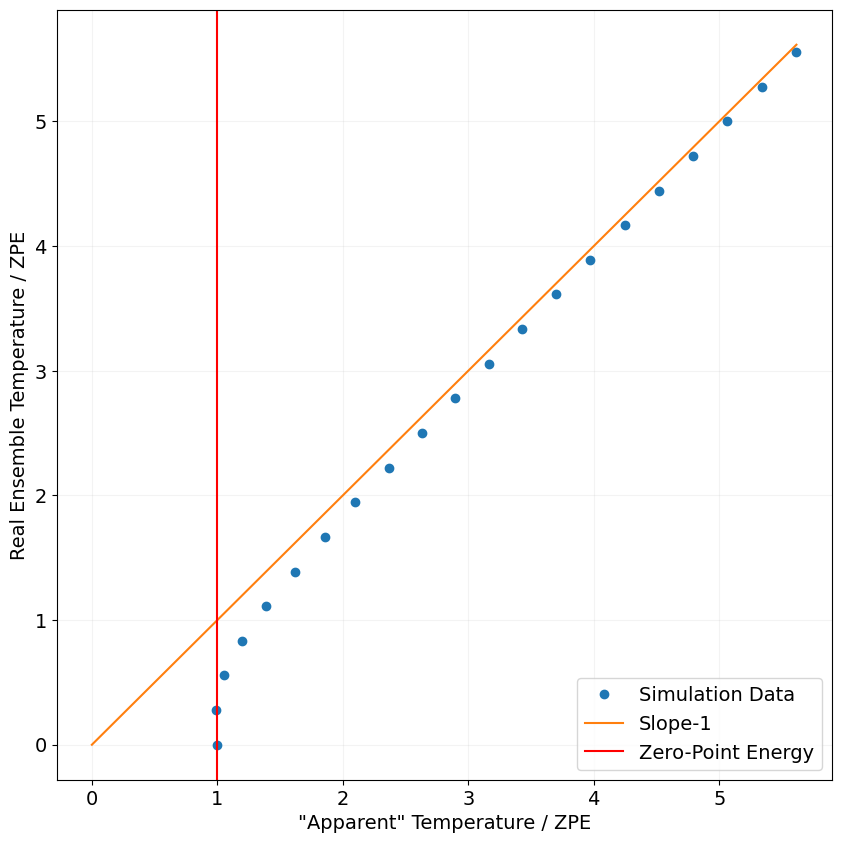

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
xpts = np.linspace(min(apparentTemperatures+list(temps)), max(apparentTemperatures+list(temps)),10)
zeroPointE=mc.hbar*2*np.pi*150e3/(2*mc.k_B)
ax.plot(np.array(apparentTemperatures)/zeroPointE,np.array(temps)/zeroPointE,'o', label='Simulation Data')
ax.set_xlabel('"Apparent" Temperature / ZPE')
ax.set_ylabel('Real Ensemble Temperature / ZPE')
ax.plot(xpts/zeroPointE,xpts/zeroPointE, label='Slope-1')

ax.axvline(1, label='Zero-Point Energy', color='r')
ax.legend()


7.198865489905905e-06

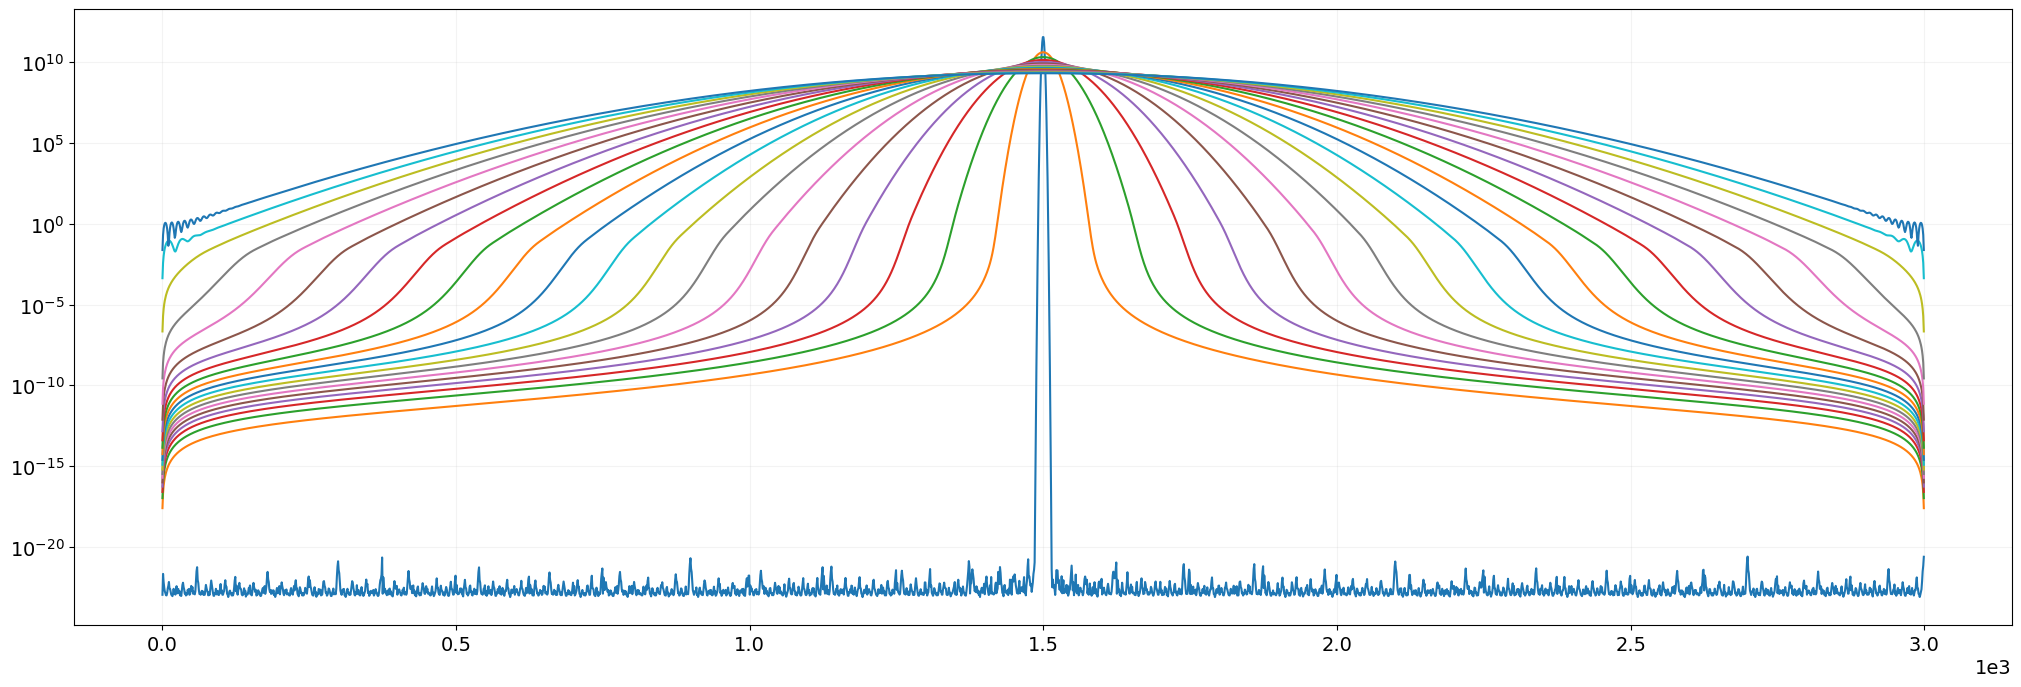

In [24]:
plt.semilogy(misc.transpose(havgs));

In [33]:
calclen = 20
temp=20e-6
res = incoherentSum(np.arange(calclen),np.zeros(int(calclen), dtype=int), getnpops(temp, calclen), 
                    numtimes=21, picSize=5e-5, numPts=3000)
images, fits, havgs, vavgs, pixsize, times, images_total = res

95.2 % Complete...


In [ ]:
animateImageSeries(times, images, interval=1000, hIntData=list(havgs), vIntData=list(vavgs), 
                   imshow_args={'cmap':'inferno'}, yticklabels=realYticklabels, ylabel=r'distance ($\mu m$)')

In [37]:
calclen = 10
temp=5e-6
res = incoherentSum(np.arange(calclen),np.zeros(int(calclen), dtype=int), getnpops(temp, calclen), 
                    numtimes=21, picSize=5e-5, numPts=3000)
images, fits, havgs, vavgs, pixsize, times, images_total = res

95.2 % Complete...


In [ ]:
animateImageSeries(times, images, interval=1000, hIntData=list(havgs), vIntData=list(vavgs), 
                   imshow_args={'cmap':'inferno'}, yticklabels=realYticklabels, ylabel=r'distance ($\mu m$)')

In [35]:
print([misc.round_sig(val) for val in getnpops(temp,20)])

[0.302, 0.211, 0.147, 0.103, 0.0716, 0.05, 0.0349, 0.0243, 0.017, 0.0118, 0.00826, 0.00577, 0.00402, 0.00281, 0.00196, 0.00137, 0.000953, 0.000665, 0.000464, 0.000324]


In [39]:
calclen = 10
temp=1e-6
res = incoherentSum(np.arange(calclen),np.zeros(int(calclen), dtype=int), getnpops(temp, calclen), 
                    numtimes=21, picSize=5e-5, numPts=3000)
images, fits, havgs, vavgs, pixsize, times, images_total = res

95.2 % Complete...


animateImageSeries(times, images, interval=1000, hIntData=list(havgs), vIntData=list(vavgs), 
                   imshow_args={'cmap':'inferno'}, yticklabels=realYticklabels, ylabel=r'distance ($\mu m$)')

## Higher Excited States

In [135]:
nu0p45 = 150e3/(np.sqrt(1000/1.5))

In [144]:
images, fits, havgs, vavgs, pixsize, times, images_total = incoherentSum([0], [0], [1], numtimes=51, clear=True, numPts=2000, nu=nu0p45, maxtime=1e-3)
np.save('N0Expansion.npy', images)

Schrodinger Propagation Progress:  98.0 % Complete...


In [145]:
animateImageSeries(times, images, interval=100, hIntData=list(havgs), vIntData=list(vavgs), 
                   imshow_args={'cmap':'inferno'}, yticklabels=realYticklabels, ylabel=r'distance ($\mu m$)')

Image Series Progress:  98.0 % Complete...


In [136]:
images, fits, havgs, vavgs, pixsize, times, images_total = incoherentSum([1], [0], [1], numtimes=51, clear=True, numPts=2000, nu=nu0p45, maxtime=1e-3)
np.save('N1Expansion.npy', images)

Schrodinger Propagation Progress:  98.0 % Complete...


In [137]:
animateImageSeries(times, images, interval=100, hIntData=list(havgs), vIntData=list(vavgs), 
                   imshow_args={'cmap':'inferno'}, yticklabels=realYticklabels, ylabel=r'distance ($\mu m$)')

Image Series Progress:  98.0 % Complete...


### n=2

In [138]:
images, fits, havgs, vavgs, pixsize, times, images_total = incoherentSum([2], [0], [1], numtimes=51, clear=True, numPts=2000, nu=nu0p45, maxtime=1e-3)
np.save('N2ExpansionTest.npy', images)

Schrodinger Propagation Progress:  98.0 % Complete...


In [139]:
animateImageSeries(times, images, interval=100, hIntData=list(havgs), vIntData=list(vavgs), 
                   imshow_args={'cmap':'inferno'}, yticklabels=realYticklabels, ylabel=r'distance ($\mu m$)')

Image Series Progress:  98.0 % Complete...


### n=3

In [140]:
images, fits, havgs, vavgs, pixsize, times, images_total = incoherentSum([3], [0], [1], numtimes=51, clear=True, numPts=2000, nu=nu0p45, maxtime=1e-3)
np.save('N3Expansion.npy', images)

Schrodinger Propagation Progress:  98.0 % Complete...


In [141]:
animateImageSeries(times, images, interval=100, hIntData=list(havgs), vIntData=list(vavgs), 
                   imshow_args={'cmap':'inferno'}, yticklabels=realYticklabels, ylabel=r'distance ($\mu m$)')

Image Series Progress:  98.0 % Complete...


### n=4

In [142]:
images, fits, havgs, vavgs, pixsize, times, images_total = incoherentSum([4], [0], [1], numtimes=51, clear=True, numPts=2000, nu=nu0p45, maxtime=1e-3)
np.save('N4Expansion.npy', images)

Schrodinger Propagation Progress:  98.0 % Complete...


In [146]:
myData = np.load('N4Expansion.npy')

In [ ]:
incoherentSum()

In [143]:
animateImageSeries(times, images, interval=100, hIntData=list(havgs), vIntData=list(vavgs), 
                   imshow_args={'cmap':'inferno'}, yticklabels=realYticklabels, ylabel=r'distance ($\mu m$)')

Image Series Progress:  98.0 % Complete...
